<a href="https://colab.research.google.com/github/liyujiel/419project/blob/master/419Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPT419 Project

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### import libs

In [0]:
import keras
from keras.models import Sequential, model_from_json, Input, Model
from keras.layers import Average, MaxPool2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping,ModelCheckpoint, TensorBoard
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

In [0]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())
keras.backend.set_session(sess)

## Baseline

### Gender model

In [0]:
gender_model.load_weights("/content/gdrive/My Drive/gender_mini_XCEPTION.21-0.95.hdf5")

### Pre-trained model

In [0]:
def baseline_model_saved(model_name):
    #load json and create model
    json_file = open('{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    #load weights from h5 file
    model.load_weights("{}.h5".format(model_name))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
    return model

In [0]:
pre_train_f = baseline_model_saved("/content/gdrive/My Drive/model_2layer_2_2_pool")

In [0]:
pre_train_s = baseline_model_saved("/content/gdrive/My Drive/model_4layer_2_2_pool") # load pre_train model

In [0]:
from keras.utils import plot_model

In [0]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

In [0]:
!pip install -q pydot


In [20]:
model = Sequential()

model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", 
                 input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))

model.add(Dense(7))
model.add(Activation('softmax'))

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='squared_hinge', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_3 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
activation_3 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_4 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
__________

In [0]:
plot_model(model, to_file='model.png', show_shapes=True)

In [74]:
pre_train_s.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 128)       512       
__________

### Emotion model

In [0]:
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
labels = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
batch_size = 256
epochs = 15

In [6]:
with open("/content/gdrive/My Drive/fer2013.csv") as f:
    content = f.readlines()

lines = np.array(content) 

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

number of instances:  35888
instance length:  2304


### initialize trainset and test set

In [0]:
x_train, y_train, x_test, y_test, x_valid, y_valid = [], [], [], [], [], []

In [0]:
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
        pixels = np.array(val, 'float32')

        emotion = keras.utils.to_categorical(emotion, num_classes)

        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
        elif 'PrivateTest' in usage:
            y_valid.append(emotion)
            x_valid.append(pixels)

    except:
    	print("",end="")

In [9]:
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')
x_valid = np.array(x_valid, 'float32')
y_valid = np.array(y_valid, 'float32')

x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255
x_valid /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')
x_valid = x_valid.reshape(x_valid.shape[0], 48, 48, 1)
x_valid = x_valid.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'valid samples')

28709 train samples
3589 test samples
3589 valid samples


In [0]:
print(x_train.shape)

(28709, 48, 48, 1)


In [0]:
input_shape = x_train[0,:,:,:].shape

In [0]:
input_shape

(48, 48, 1)

In [0]:
model_input = Input(shape=input_shape)

In [0]:
# m_x_train, m_y_train, m_x_test, m_y_test, m_x_valid, m_y_valid = [], [], [], [], [], []

In [0]:
# f_x_train, f_y_train, f_x_test, f_y_test, f_x_valid, f_y_valid = [], [], [], [], [], []

In [0]:
# import cv2

In [0]:
for i in range(0,len(x_train)):
    per_x_train = x_train[i]
    per_y_train = y_train[i]
    per_x_train = cv2.resize(per_x_train,(64,64),1)
    per_x_train = per_x_train.reshape(1, 64, 64, -1)
    print(gender_model.predict(per_x_train))
    if gender_model.predict(per_x_train)[0][0] >= 0.5:
        m_x_train.append(per_x_train)
    else:
        f_x_train.append(per_x_train)   

In [0]:
for per_y_train in y_train:
    if gender_model.predict(per_y_train)[0] == 1:
        m_y_train.append(per_y_train)
    else:
        f_y_train.append(per_y_train)

In [0]:
for per_x_test in x_test:
    if gender_model.predict(per_x_test)[0] == 1:
        m_x_test.append(per_x_test)
    else:
        f_x_test.append(per_x_test)  

In [0]:
for per_y_test in y_test:
    if gender_model.predict(per_y_test)[0] == 1:
        m_y_test.append(per_y_test)
    else:
        f_y_test.append(per_y_test)  

In [0]:
for per_x_valid in x_valid:
    if gender_model.predict(per_x_valid)[0] == 1:
        m_x_valid.append(per_x_valid)
    else:
        f_x_valid.append(per_x_valid)  

In [0]:
for per_y_valid in y_valid:
    if gender_model.predict(per_y_valid)[0] == 1:
        m_y_valid.append(per_y_valid)
    else:
        f_y_valid.append(per_y_valid)  

In [0]:
m_x_train = np.array(m_x_train, 'float32')
m_y_train = np.array(m_y_train, 'float32')
m_x_test = np.array(m_x_test, 'float32')
m_y_test = np.array(m_y_test, 'float32')
m_x_valid = np.array(m_x_valid, 'float32')
m_y_valid = np.array(m_y_valid, 'float32')

f_x_train = np.array(f_x_train, 'float32')
f_y_train = np.array(f_y_train, 'float32')
f_x_test = np.array(f_x_test, 'float32')
f_y_test = np.array(f_y_test, 'float32')
f_x_valid = np.array(f_x_valid, 'float32')
f_y_valid = np.array(f_y_valid, 'float32')

In [0]:
valid = (x_valid, y_valid)

### Baseline Net

In [0]:
def base_cnn_model(img_shape=(48, 48, 1), n_classes=7):
    #construct CNN structure
    model = Sequential()

    #1st convolution layer
    model.add(Conv2D(64, (5, 5), activation='relu', input_shape=img_shape))
    model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

    #2nd convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

    #3rd convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

    model.add(Flatten())

    #fully connected neural networks
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(n_classes, activation='softmax'))
    
    return model

In [0]:
# model = base_cnn_model()

### AlexNet

In [0]:
def alexnet_model(img_shape=(48, 48, 1), n_classes=7, l2_reg=0.1,
	weights=None):

	# Initialize model
	alexnet = Sequential()

	# Layer 1
	alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape,
		padding='same', kernel_regularizer=l2(l2_reg)))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 2
	alexnet.add(Conv2D(256, (5, 5), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(512, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 4
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))

	# Layer 5
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 6
	alexnet.add(Flatten())
	alexnet.add(Dense(3072))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 7
	alexnet.add(Dense(4096))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 8
	alexnet.add(Dense(n_classes))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('softmax'))

	if weights is not None:
		alexnet.load_weights(weights)

	return alexnet

In [0]:
model = alexnet_model()

### ResNet50

In [0]:
# from keras import applications

In [0]:
# model = keras.applications.resnet50.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=(48, 48, 1), pooling=None, classes=7)

### VGG19

In [0]:
def vgg19_model(img_shape=(48, 48, 1), n_classes=7, l2_reg=0.1,
	weights=None):

	# Initialize model
	vgg19 = Sequential()

	# Layer 1 & 2
	vgg19.add(Conv2D(64, (3, 3), padding='same',
		input_shape=img_shape, kernel_regularizer=l2(l2_reg)))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(64, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3 & 4
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(128, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(128, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 5, 6, 7, & 8
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(256, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(256, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(256, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(256, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(MaxPooling2D(pool_size=(2, 2)))

	# Layers 9, 10, 11, & 12
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(MaxPooling2D(pool_size=(2, 2)))

	# Layers 13, 14, 15, & 16
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(MaxPooling2D(pool_size=(2, 2)))

	# Layers 17, 18, & 19
	vgg19.add(Flatten())
	vgg19.add(Dense(4096))
	vgg19.add(Activation('relu'))
	vgg19.add(Dropout(0.5))
	vgg19.add(Dense(4096))
	vgg19.add(Activation('relu'))
	vgg19.add(Dropout(0.5))
	vgg19.add(Dense(n_classes))
	vgg19.add(Activation('softmax'))

	if weights is not None:
		vgg19.load_weights(weights)

	return vgg19

In [0]:
# model = vgg19_model()

### VGG16

In [0]:
# model = keras.applications.vgg16.VGG16(include_top=True, weights=None, input_tensor=None, input_shape=(48,48,1), pooling=None, classes=7)

### Model init

In [0]:
#batch process
gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

In [0]:
filepath="/content/gdrive/My Drive/weights_base_new_opt.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
model.compile(loss='categorical_crossentropy'
    , optimizer=keras.optimizers.Adam()
    , metrics=['accuracy']
)

NameError: ignored

In [0]:
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batch_size,
                         write_images=True)

In [0]:
model = keras.models.load_model("/content/gdrive/My Drive/weights_base.best.hdf5") # 99% acc

### TPU model

In [0]:
# tf.keras.backend.clear_session()

In [0]:
# tpu_model = tf.contrib.tpu.keras_support.tpu_model(
#     model,
#     strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

### Train model

In [0]:
fit = False

if fit == True:
	#model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
	model.fit_generator(train_generator, validation_data=valid, steps_per_epoch=batch_size, epochs=epochs, callbacks=[checkpoint, tensor_board]) #train for randomly selected one
else:
	model.load_weights('/content/gdrive/My Drive/alex_net_epoch25.h5') #load weights

In [0]:
model_input

<tf.Tensor 'input_9:0' shape=(?, 48, 48, 1) dtype=float32>

In [0]:
models = [model, pre_train_f, pre_train_s]

In [0]:
from keras import layers

In [70]:
def ensemble(models, model_input):
    
    outputs = [model(model_input) for model in models]

    y = layers.average(outputs) 
    
    model = Model(model_input, y, name='ensemble')
    
    return model

ensemble_model = ensemble(models, model_input)

ValueError: ignored

In [0]:
print(ensemble_model)

In [0]:
ensemble_model.compile(loss='categorical_crossentropy'
    , optimizer=keras.optimizers.Adam()
    , metrics=['accuracy']
)

In [33]:
best_model.fit_generator(train_generator, validation_data=valid, steps_per_epoch=batch_size, epochs=epochs, callbacks=[checkpoint]) #train for randomly selected one

Epoch 1/15
256/256 [==============================] - 222s 866ms/step - loss: 0.0078 - acc: 0.9970 - val_loss: 2.5201 - val_acc: 0.5272

Epoch 00001: val_acc did not improve from 0.61215
Epoch 2/15
256/256 [==============================] - 222s 867ms/step - loss: 0.0847 - acc: 0.9720 - val_loss: 1.8328 - val_acc: 0.5704

Epoch 00002: val_acc did not improve from 0.61215
Epoch 3/15
256/256 [==============================] - 221s 865ms/step - loss: 0.0158 - acc: 0.9948 - val_loss: 2.0212 - val_acc: 0.6124

Epoch 00003: val_acc improved from 0.61215 to 0.61243, saving model to /content/gdrive/My Drive/weights_base.best.hdf5
Epoch 4/15
256/256 [==============================] - 221s 865ms/step - loss: 0.0067 - acc: 0.9974 - val_loss: 2.0024 - val_acc: 0.6127

Epoch 00004: val_acc improved from 0.61243 to 0.61271, saving model to /content/gdrive/My Drive/weights_base.best.hdf5
Epoch 5/15
256/256 [==============================] - 222s 865ms/step - loss: 0.0051 - acc: 0.9978 - val_loss: 2.0

In [0]:
best_model = keras.models.load_model("/content/gdrive/My Drive/weights_base.best.hdf5")

In [71]:
y_prob = best_model.predict(x_test)
y_pred = best_model.predict_classes(x_test)
y_test_true = [ np.argmax(item) for item in y_test]
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_true, y_pred)

array([[256,   3,  53,  29,  78,  10,  38],
       [ 17,  27,   3,   3,   2,   0,   4],
       [ 53,   2, 212,  24, 105,  29,  71],
       [ 34,   1,  25, 702,  48,  19,  66],
       [ 91,   1,  76,  50, 340,  10,  85],
       [ 17,   0,  42,  18,  10, 309,  19],
       [ 73,   1,  53,  56, 116,   4, 304]])

In [0]:
labels = ['Angry', 'Disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
import matplotlib.pyplot as plt
import matplotlib
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(7,7))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    ax.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

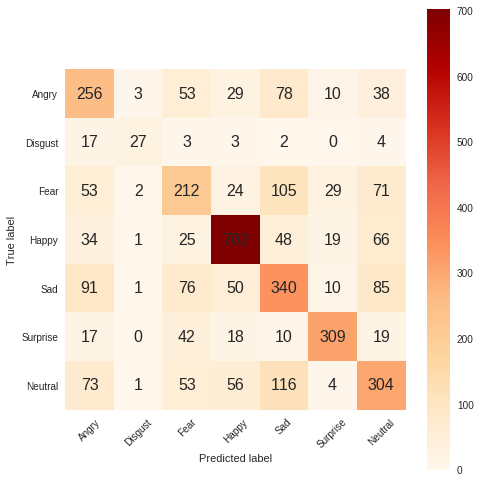

In [73]:
plot_confusion_matrix(y_test_true, y_pred, cmap=plt.cm.OrRd)

In [12]:
score = best_model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', 100*score[1])

3589/3589 [==============================] - 10s 3ms/step
Test loss: 2.1044667149759264
Test accuracy: 59.905266091248286


In [0]:
y_pred = best_model.predict(x_test)

In [0]:
y_true = [np.argmax(true) for true in y_test]
y_pred_true = [np.argmax(true) for true in y_pred]
accs = list()
precs = list()
recalls = list()

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
def class_precision(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    col = [cm[j,i] for j in range(0,len(labels))]
    return float(col[i])/sum(col)

def class_recall(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    row = [cm[i,j] for j in range(0,len(labels))]
    return float(row[i])/sum(row)

def class_accuracy(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    tp = cm[i,i]
    fn = sum([cm[i,j] for j in range(0,6) if j != i])
    fp = sum([cm[j,i] for j in range(0,6) if j != i])
    tn = sum([cm[i,j] for j in range(0,6) for i in range(0,6)]) -(tp+fp+fn)
    return float(tp + tn)/sum([tp, fn, fp, tn])

In [0]:
from sklearn.metrics import precision_score, recall_score

In [58]:
recall_score(y_true, y_pred_true, average='weighted')

0.599052660908331

In [0]:
def prec_precision(y_true, y_pred_true):
    return precision_score(y_true, y_pred_true, average='macro')
    

In [53]:
prec_precision(y_true, y_pred_true)

0.6161088020362141

In [0]:
def prec_acc(y_true, y_pred_true):
    count = 0
    for i in range(0, len(y_true)):
        if y_true[i] == y_pred_true[i]:
            count += 1
    return count/len(y_true)

In [25]:
prec_acc(y_true, y_pred_true)

0.599052660908331

In [0]:
plot_vals = list()

In [134]:
for emotion in labels:
    print(emotion.upper())
    acc = class_accuracy(y_true, y_pred_true, emotion)
    acc_list = ['acc', emotion, acc]
    prec = class_precision(y_true, y_pred_true, emotion)
    prec_list = ['prec', emotion, prec]
    recall = class_recall(y_true, y_pred_true, emotion)
    recall_list = ['recall', emotion, recall]
    plot_vals.append(acc_list)
    plot_vals.append(prec_list)
    plot_vals.append(recall_list)
    print('   acc = {}'.format(acc))
    print('  prec = {}'.format(prec))
    print('recall = {}\n'.format(recall))

ANGRY
   acc = 0.8573545757688033
  prec = 0.4731977818853974
recall = 0.5481798715203426

DISGUST
   acc = 0.9881437569470174
  prec = 0.7714285714285715
recall = 0.48214285714285715

FEAR
   acc = 0.8473508706928492
  prec = 0.45689655172413796
recall = 0.4274193548387097

HAPPY
   acc = 0.9070025935531678
  prec = 0.7959183673469388
recall = 0.7843575418994413

SAD
   acc = 0.8254909225639125
  prec = 0.4864091559370529
recall = 0.5206738131699847

SURPRISE
   acc = 0.9425713227121156
  prec = 0.8110236220472441
recall = 0.744578313253012

NEUTRAL
   acc = 0.7828825490922564
  prec = 0.5178875638841567
recall = 0.500823723228995



In [86]:
precs

[0.4731977818853974,
 0.7714285714285715,
 0.45689655172413796,
 0.7959183673469388,
 0.4864091559370529,
 0.8110236220472441,
 0.5178875638841567]

In [0]:
%matplotlib inline

In [135]:
plot_vals

[['acc', 'angry', 0.8573545757688033],
 ['prec', 'angry', 0.4731977818853974],
 ['recall', 'angry', 0.5481798715203426],
 ['acc', 'disgust', 0.9881437569470174],
 ['prec', 'disgust', 0.7714285714285715],
 ['recall', 'disgust', 0.48214285714285715],
 ['acc', 'fear', 0.8473508706928492],
 ['prec', 'fear', 0.45689655172413796],
 ['recall', 'fear', 0.4274193548387097],
 ['acc', 'happy', 0.9070025935531678],
 ['prec', 'happy', 0.7959183673469388],
 ['recall', 'happy', 0.7843575418994413],
 ['acc', 'sad', 0.8254909225639125],
 ['prec', 'sad', 0.4864091559370529],
 ['recall', 'sad', 0.5206738131699847],
 ['acc', 'surprise', 0.9425713227121156],
 ['prec', 'surprise', 0.8110236220472441],
 ['recall', 'surprise', 0.744578313253012],
 ['acc', 'neutral', 0.7828825490922564],
 ['prec', 'neutral', 0.5178875638841567],
 ['recall', 'neutral', 0.500823723228995]]

In [0]:
import pandas as pd

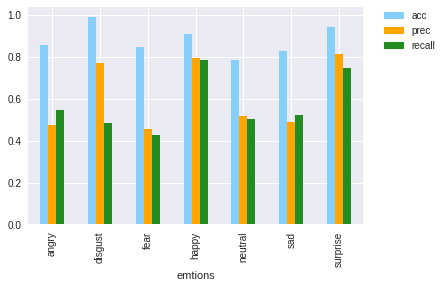

In [153]:
df = pd.DataFrame(plot_vals, columns=['','emtions','percentage'])

pivot = df.pivot("emtions", "", "percentage")

pivot.plot(kind='bar', color=['lightskyblue', 'orange', 'forestgreen'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

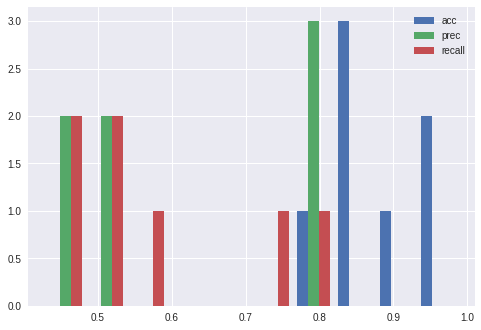

In [73]:
x = np.arange(num_classes)
plt.hist((accs, precs, recalls), label = ("acc", "prec", "recall"))
plt.legend()

# labels
# plt.xticks(x, tuple(labels))

In [0]:
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/client
+ localtunnel@1.9.1
added 54 packages from 32 contributors in 2.808s


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')


In [0]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

--2018-12-09 02:37:22--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.60.111, 52.55.191.55, 52.201.75.180, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.60.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  3.53MB/s    in 1.5s    

2018-12-09 02:37:25 (3.53 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://da497423.ngrok.io


In [0]:
rm -r '/content/gdrive/My Drive/419Project.tbgraph'

In [0]:
y_classes

In [0]:
score = model.predict(x_test)
y_classes = score.argmax(axis=-1)

In [0]:
model.save('/content/gdrive/My Drive/alexnet_epoch15_batch256.h5')

In [0]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()


In [0]:
monitor_testset_results = False

if monitor_testset_results == True:
	#make predictions for test set
	predictions = model.predict(x_test)

	index = 0
	for i in predictions:
		if index < 30 and index >= 20:
			#print(i) #predicted scores
			#print(y_test[index]) #actual scores
			
			testing_img = np.array(x_test[index], 'float32')
			testing_img = testing_img.reshape([48, 48]);
			
			plt.gray()
			plt.imshow(testing_img)
			plt.show()
			
			print(i)
			
			emotion_analysis(i)
			print("----------------------------------------------")
		index = index + 1

### Test Picture

In [0]:
!wget https://nricafe.com/wp-content/uploads/2015/09/Happy-Indian.jpg

--2018-12-04 06:20:36--  https://nricafe.com/wp-content/uploads/2015/09/Happy-Indian.jpg
Resolving nricafe.com (nricafe.com)... 104.27.184.42, 104.27.185.42, 2606:4700:30::681b:b92a, ...
Connecting to nricafe.com (nricafe.com)|104.27.184.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69751 (68K) [image/jpeg]
Saving to: ‘Happy-Indian.jpg’

Happy-Indian.jpg    100%[===================>]  68.12K  --.-KB/s    in 0.007s  

2018-12-04 06:20:37 (8.93 MB/s) - ‘Happy-Indian.jpg’ saved [69751/69751]



/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


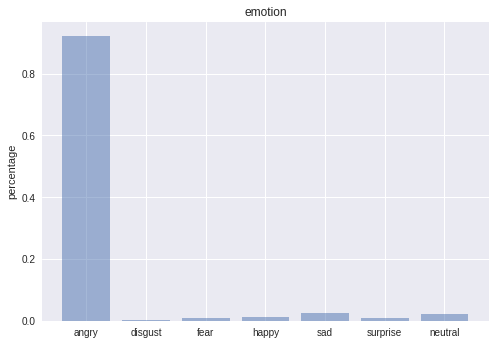

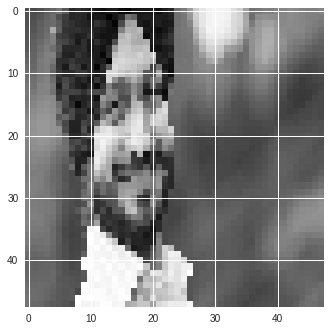

In [0]:
img = image.load_img("Happy-Indian.jpg", grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()